In [10]:
import torch
print(torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [11]:
# import libraires
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as T

In [12]:
# Dataset class for training the gas concentration prediction model
class GasConcentrationDataset(Dataset):
    def __init__(self, data_dir, augment=False):
        self.data_dir = data_dir
        self.feature_maps = []
        self.labels = []
        self.augment = augment
        self.load_data()
        
        # Augmentation only for training
        self.augment_transform = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            T.RandomRotation(degrees=30),
            T.RandomResizedCrop(size=(64, 64), scale=(0.9, 1.1))
        ])
    
    def normalize(self, data):
        """Normalize data to [0, 1]"""
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    def load_data(self):
        # Load map folders
        map_dirs = [os.path.join(self.data_dir, d) for d in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, d))]

        for map_dir in map_dirs:
            feature_map_dir = os.path.join(map_dir, 'feature_map')

            # feature_map folder
            if os.path.exists(feature_map_dir):
                sim_dirs = [os.path.join(feature_map_dir, d) for d in os.listdir(feature_map_dir) if os.path.isdir(os.path.join(feature_map_dir, d))]

                for sim_dir in sim_dirs:
                    try:
                        # Load the feature maps
                        flow_map = np.load(os.path.join(sim_dir, 'flow_definition_map.npy'))
                        sdf_map = np.load(os.path.join(sim_dir, 'sdf_map.npy'))
                        inv_dist_map = np.load(os.path.join(sim_dir, 'inverse_distance_map.npy'))
                        
                        # Normalize the maps
                        flow_map = self.normalize(flow_map)
                        sdf_map = self.normalize(sdf_map)
                        inv_dist_map = self.normalize(inv_dist_map)
                        
                        # Stack the feature maps into a 3-channel tensor 
                        feature_map = np.stack([flow_map, sdf_map, inv_dist_map], axis=0)
                        
                        # Load the label (gas concentration map)
                        label = np.load(os.path.join(sim_dir, 'gas_concentration_map.npy'))
                        label = self.normalize(label)  # Label도 정규화

                        # Append to lists
                        self.feature_maps.append(feature_map)
                        self.labels.append(label)
                    except FileNotFoundError:
                        print(f"Missing data in {sim_dir}, skipping...")
                    except Exception as e:
                        print(f"Error loading data from {sim_dir}: {e}, skipping...")

    def __len__(self):
        return len(self.feature_maps)

    def __getitem__(self, idx):
        feature_map = torch.tensor(self.feature_maps[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32).unsqueeze(0)
        
        if self.augment:
            feature_map = self.augment_transform(feature_map)
        
        return feature_map, label

# Dataset loading
data_dir = "/home/piai/PABA/gaden/install/test_env/share/test_env/scenarios/2_suc_map"

# Separate loading of train and validation datasets
train_dataset = GasConcentrationDataset(data_dir, augment=True)  # Train dataset에만 augment 적용
val_dataset = GasConcentrationDataset(data_dir, augment=False)  # Validation dataset에는 augment 적용하지 않음

# DataLoader for batching 
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

def check_dataset_loading(loader):
    for feature_maps, labels in loader:
        print("Feature Map Shape:", feature_maps.shape)  # (batch_size, 3, 64, 64)
        print("Label Shape:", labels.shape)  # (batch_size, 1, 64, 64)
        break  # 첫 번째 batch만 확인
    
check_dataset_loading(train_loader)

Missing data in /home/piai/PABA/gaden/install/test_env/share/test_env/scenarios/2_suc_map/map39/feature_map/sim6, skipping...
Missing data in /home/piai/PABA/gaden/install/test_env/share/test_env/scenarios/2_suc_map/map81/feature_map/sim10, skipping...
Missing data in /home/piai/PABA/gaden/install/test_env/share/test_env/scenarios/2_suc_map/map91/feature_map/sim13, skipping...
Missing data in /home/piai/PABA/gaden/install/test_env/share/test_env/scenarios/2_suc_map/map09/feature_map/sim1, skipping...
Missing data in /home/piai/PABA/gaden/install/test_env/share/test_env/scenarios/2_suc_map/map39/feature_map/sim6, skipping...
Missing data in /home/piai/PABA/gaden/install/test_env/share/test_env/scenarios/2_suc_map/map81/feature_map/sim10, skipping...
Missing data in /home/piai/PABA/gaden/install/test_env/share/test_env/scenarios/2_suc_map/map91/feature_map/sim13, skipping...
Missing data in /home/piai/PABA/gaden/install/test_env/share/test_env/scenarios/2_suc_map/map09/feature_map/sim1, 

In [13]:
def create_layer(in_channels, out_channels, kernel_size, wn=True, bn=True, dropout_prob=0.3,
                 activation=nn.ReLU, convolution=nn.Conv2d):
    assert kernel_size % 2 == 1
    layer = []
    conv = convolution(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
    if wn:
        conv = weight_norm(conv)
    layer.append(conv)
    if activation is not None:
        layer.append(activation())
    if bn:
        layer.append(nn.BatchNorm2d(out_channels))
    if dropout_prob > 0:  # Dropout이 활성화된 경우에만 적용
        layer.append(nn.Dropout(dropout_prob))
    return nn.Sequential(*layer)

def create_encoder(in_channels, filters, kernel_size, wn=True, bn=True, activation=nn.ReLU, layers=2, dropout_prob=0.3):
    encoder = []
    for i in range(len(filters)):
        if i == 0:
            encoder_layer = create_encoder_block(in_channels, filters[i], kernel_size, wn, bn, activation, layers, dropout_prob=dropout_prob)
        else:
            encoder_layer = create_encoder_block(filters[i-1], filters[i], kernel_size, wn, bn, activation, layers, dropout_prob=dropout_prob)
        encoder = encoder + [encoder_layer]
    return nn.Sequential(*encoder)

def create_decoder(out_channels, filters, kernel_size, wn=True, bn=True, activation=nn.ReLU, layers=2, dropout_prob=0.3):
    decoder = []
    for i in range(len(filters)):
        if i == 0:
            decoder_layer = create_decoder_block(filters[i], out_channels, kernel_size, wn, bn, activation, layers, dropout_prob=dropout_prob, final_layer=True)
        else:
            decoder_layer = create_decoder_block(filters[i], filters[i-1], kernel_size, wn, bn, activation, layers, dropout_prob=dropout_prob, final_layer=False)
        decoder = [decoder_layer] + decoder
    return nn.Sequential(*decoder)

def create_encoder_block(in_channels, out_channels, kernel_size, wn=True, bn=True, 
                         activation=nn.ReLU, layers=2, dropout_prob=0.3):  # dropout_prob는 여기 남아있습니다.
    encoder = []
    for i in range(layers):
        _in = out_channels
        _out = out_channels
        if i == 0:
            _in = in_channels
        # dropout_prob는 create_layer에만 넘겨줍니다.
        encoder.append(create_layer(_in, _out, kernel_size, wn, bn, dropout_prob, activation, nn.Conv2d))
    return nn.Sequential(*encoder)

def create_decoder_block(in_channels, out_channels, kernel_size, wn=True, bn=True, 
                         activation=nn.ReLU, layers=2, final_layer=False, dropout_prob=0.3):
    decoder = []
    for i in range(layers):
        _in = in_channels
        _out = in_channels
        _bn = bn
        _activation = activation
        if i == 0:
            _in = in_channels * 2
        if i == layers - 1:
            _out = out_channels
            if final_layer:
                _bn = False
                _activation = None
        # dropout_prob는 create_layer에만 넘겨줍니다.
        decoder.append(create_layer(_in, _out, kernel_size, wn, _bn, dropout_prob, _activation, nn.ConvTranspose2d))
    return nn.Sequential(*decoder)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, filters=[16, 32, 64], layers=2,
                 weight_norm=True, batch_norm=True, activation=nn.ReLU, dropout_prob=0.3, final_activation=None):
        super().__init__()
        assert len(filters) > 0
        self.final_activation = final_activation
        self.encoder = create_encoder(in_channels, filters, kernel_size, weight_norm, batch_norm, activation, layers, dropout_prob=dropout_prob)
        self.decoder = create_decoder(out_channels, filters, kernel_size, weight_norm, batch_norm, activation, layers, dropout_prob=dropout_prob)

    def encode(self, x):
        tensors = []
        indices = []
        sizes = []
        for encoder in self.encoder:
            x = encoder(x)
            sizes.append(x.size())
            tensors.append(x)
            x, ind = F.max_pool2d(x, 2, 2, return_indices=True)
            indices.append(ind)
        return x, tensors, indices, sizes

    def decode(self, x, tensors, indices, sizes):
        for decoder in self.decoder:
            tensor = tensors.pop()
            size = sizes.pop()
            ind = indices.pop()
            x = F.max_unpool2d(x, ind, 2, 2, output_size=size)
            x = torch.cat([tensor, x], dim=1)
            x = decoder(x)
        return x

    def forward(self, x):
        x, tensors, indices, sizes = self.encode(x)
        x = self.decode(x, tensors, indices, sizes)

        # 업샘플링: 출력 크기를 104x64로 변경
        x = F.interpolate(x, size=(104, 64), mode='bilinear', align_corners=False)

        if self.final_activation is not None:
            x = self.final_activation(x)
        return x

In [20]:
# Model train and validation with early stopping and progress bar
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=1000, model_path='best_model.pth', patience=10):
    best_val_loss = float('inf')  # Initialize with a very large value
    train_losses = []
    val_losses = []
    epochs_without_improvement = 0  # Count how many epochs since last improvement

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # Progress bar for training
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                # Track loss
                running_loss += loss.item()
                pbar.set_postfix({'Train Loss': running_loss / (pbar.n + 1)})
                pbar.update(1)
                
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # update learning rate
        scheduler.step(val_loss)

        # Check if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print(f'Epoch {epoch+1}: Validation loss improved to {val_loss:.4f}, model saved as {model_path}')
            epochs_without_improvement = 0  # Reset the counter if validation improves
        else:
            epochs_without_improvement += 1
            print(f'Epoch {epoch+1}: No improvement in validation loss. {epochs_without_improvement} epochs without improvement.')

        # Check early stopping condition
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}. No improvement in {patience} consecutive epochs.")
            break

        # Epoch logging every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')
    
    return train_losses, val_losses

# Loss visualization
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


Epoch 1/100: 100%|██████████| 77/77 [00:03<00:00, 22.34batch/s, Train Loss=1.05]


Epoch 1: Validation loss improved to 0.3839, model saved as best_model.pth


Epoch 2/100: 100%|██████████| 77/77 [00:03<00:00, 22.97batch/s, Train Loss=0.645]


Epoch 2: Validation loss improved to 0.3754, model saved as best_model.pth


Epoch 3/100: 100%|██████████| 77/77 [00:03<00:00, 22.58batch/s, Train Loss=0.54] 


Epoch 3: Validation loss improved to 0.3234, model saved as best_model.pth


Epoch 4/100: 100%|██████████| 77/77 [00:03<00:00, 22.11batch/s, Train Loss=0.495]


Epoch 4: No improvement in validation loss. 1 epochs without improvement.


Epoch 5/100: 100%|██████████| 77/77 [00:03<00:00, 22.50batch/s, Train Loss=0.481]


Epoch 5: No improvement in validation loss. 2 epochs without improvement.


Epoch 6/100: 100%|██████████| 77/77 [00:03<00:00, 22.43batch/s, Train Loss=0.477]


Epoch 6: No improvement in validation loss. 3 epochs without improvement.


Epoch 7/100: 100%|██████████| 77/77 [00:03<00:00, 23.07batch/s, Train Loss=0.464]


Epoch 7: No improvement in validation loss. 4 epochs without improvement.


Epoch 8/100: 100%|██████████| 77/77 [00:03<00:00, 22.65batch/s, Train Loss=0.453]


Epoch 8: Validation loss improved to 0.3206, model saved as best_model.pth


Epoch 9/100: 100%|██████████| 77/77 [00:03<00:00, 22.27batch/s, Train Loss=0.445]


Epoch 9: No improvement in validation loss. 1 epochs without improvement.


Epoch 10/100: 100%|██████████| 77/77 [00:03<00:00, 22.73batch/s, Train Loss=0.44] 


Epoch 10: No improvement in validation loss. 2 epochs without improvement.


Epoch 11/100: 100%|██████████| 77/77 [00:03<00:00, 22.26batch/s, Train Loss=0.436]


Epoch 11: No improvement in validation loss. 3 epochs without improvement.


Epoch 12/100: 100%|██████████| 77/77 [00:03<00:00, 22.61batch/s, Train Loss=0.433]


Epoch 12: No improvement in validation loss. 4 epochs without improvement.


Epoch 13/100: 100%|██████████| 77/77 [00:03<00:00, 22.67batch/s, Train Loss=0.43] 


Epoch 13: No improvement in validation loss. 5 epochs without improvement.
Early stopping at epoch 13. No improvement in 5 consecutive epochs.


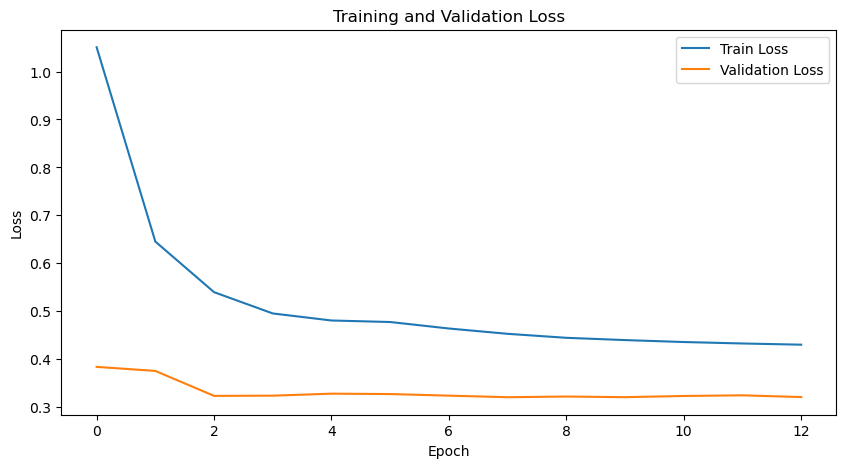

In [33]:
# Hyperparameters
kernel_size=5
filters=[8, 16, 32, 32]
lr=0.0005
weight_decay=0.01
in_channels=3
out_channels=1

num_epochs=100
factor=0.1
patience=5
dropout_prob=0.5


# model initialization
model = UNet(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, 
             filters=filters, dropout_prob=dropout_prob).to(device)

# loss function and optimizer
criterion = nn.L1Loss() # L1 Loss for regression
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, verbose=True)

# model training
train_losses, val_losses = train_model(model, train_loader, val_loader, 
                                        criterion, optimizer, scheduler, num_epochs=num_epochs, patience=patience)

plot_losses(train_losses, val_losses)

Sample 1:


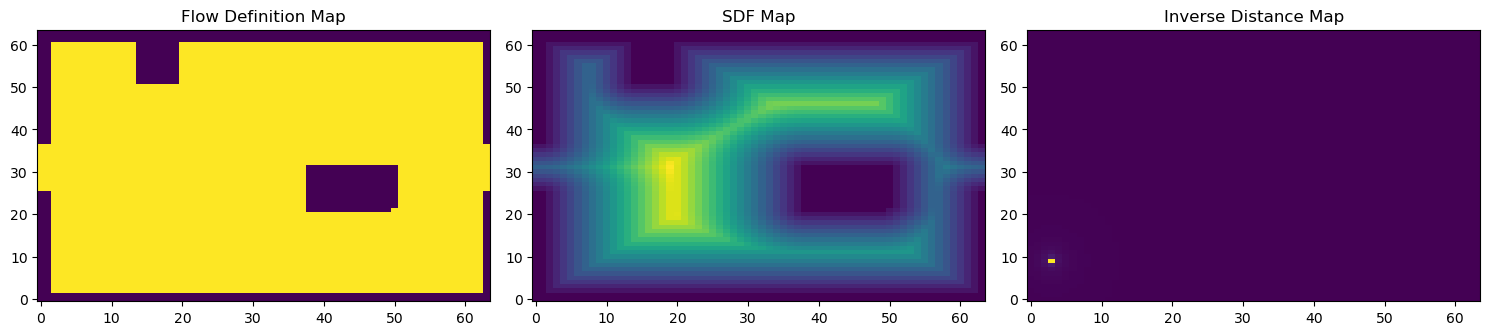

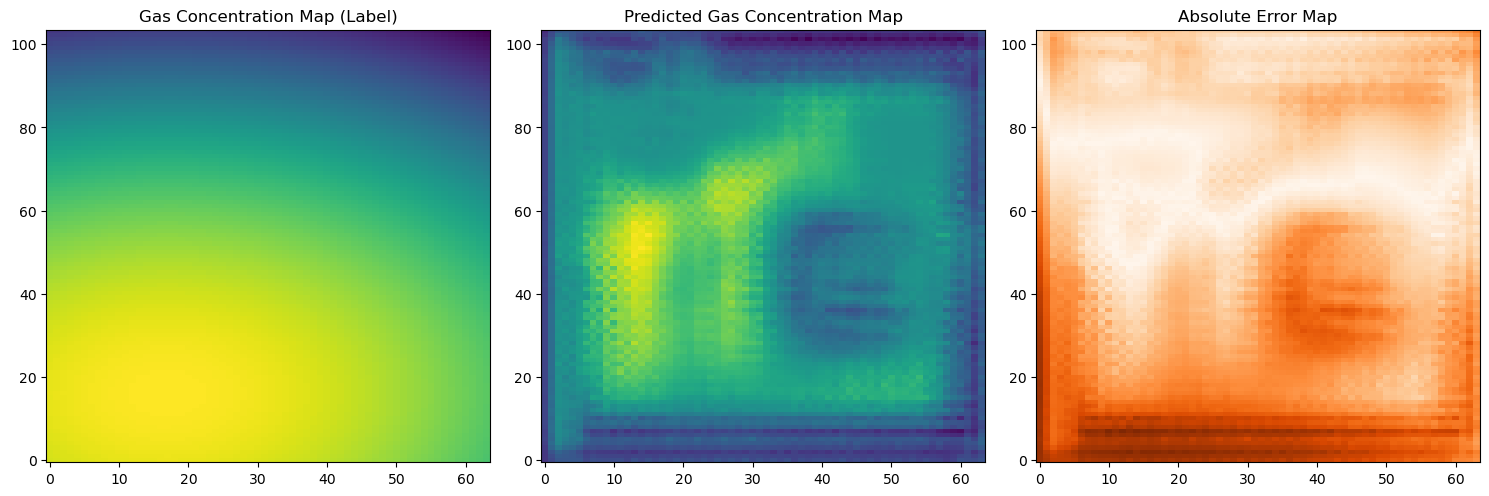

Sample 2:


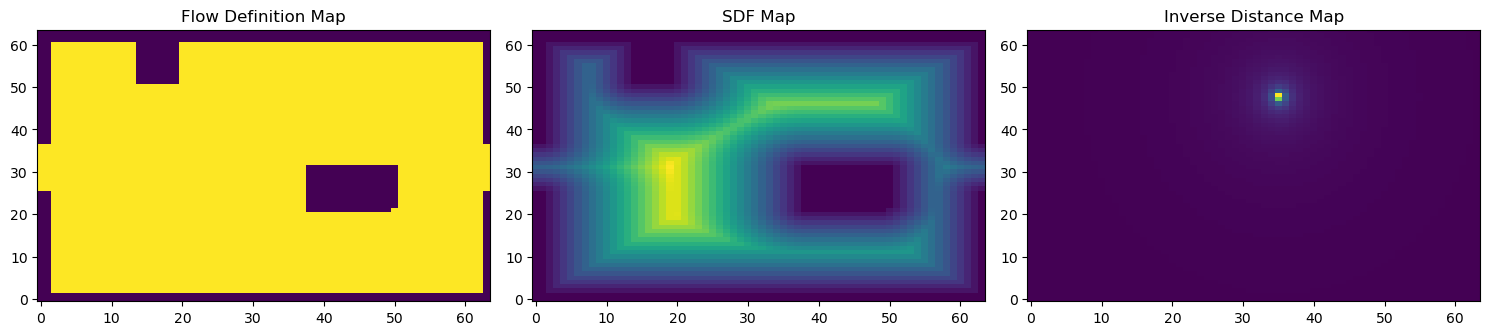

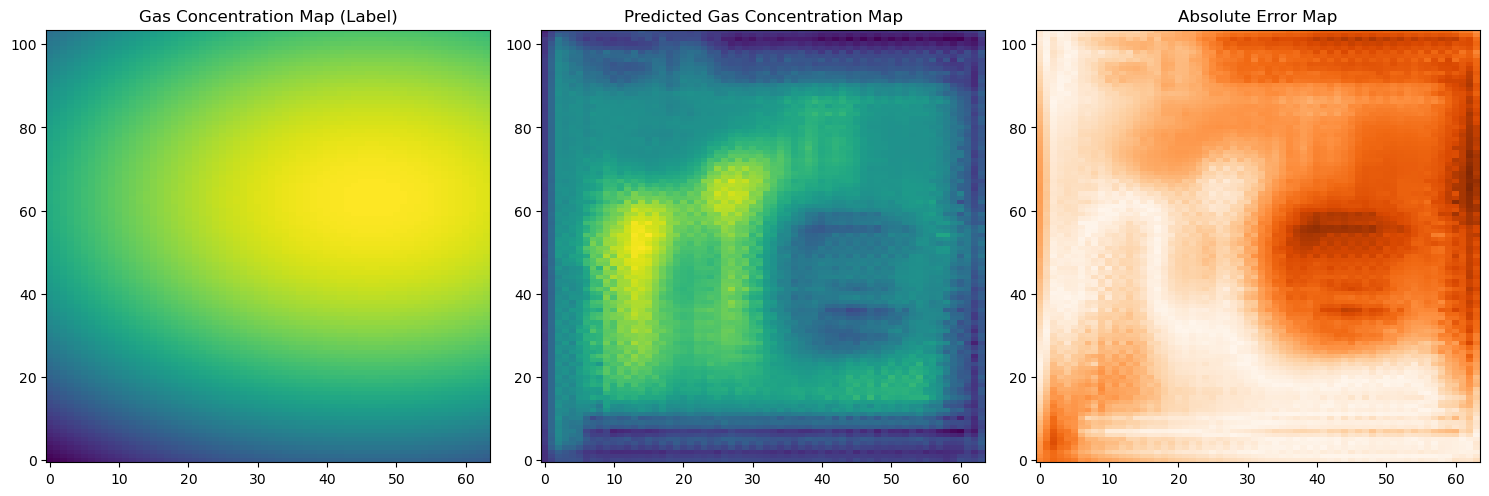

Sample 3:


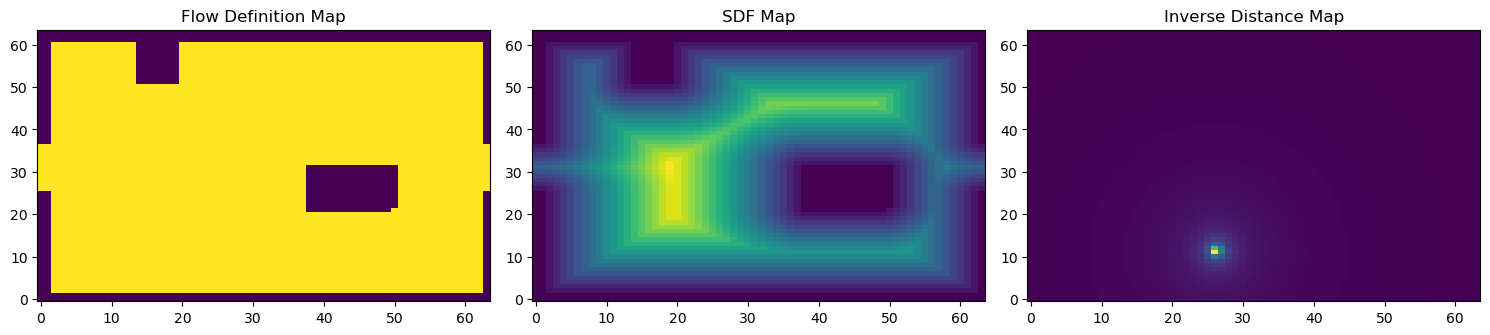

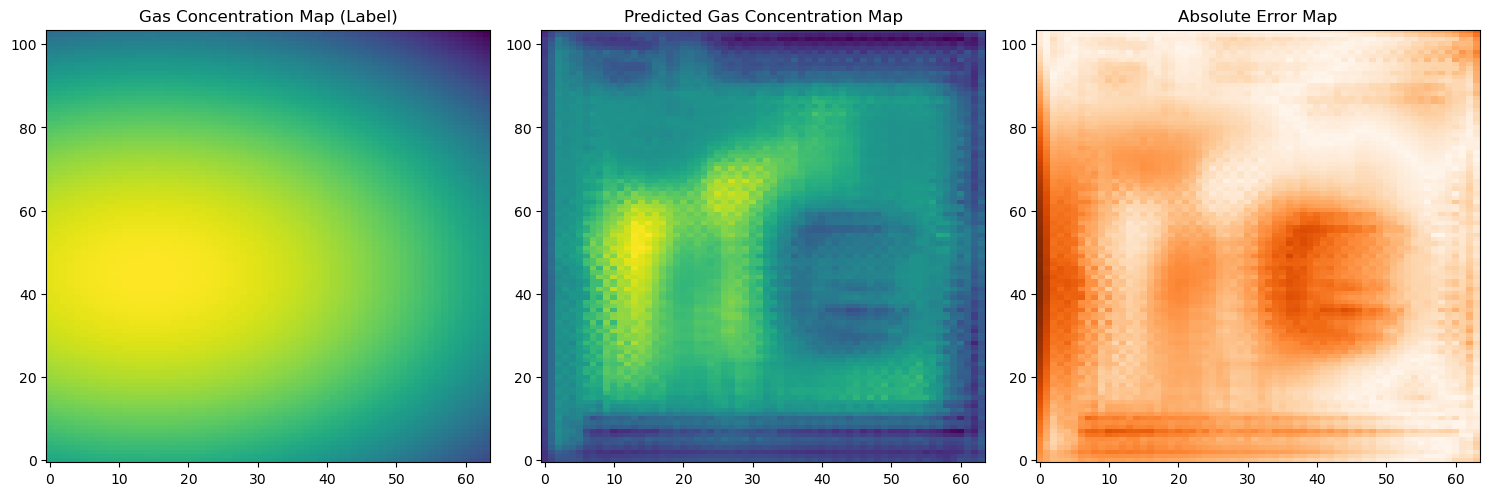

Sample 4:


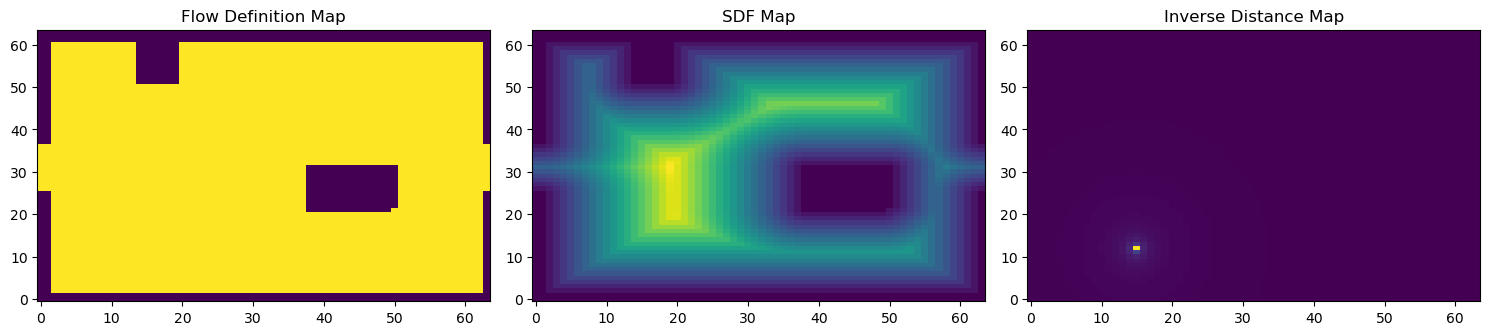

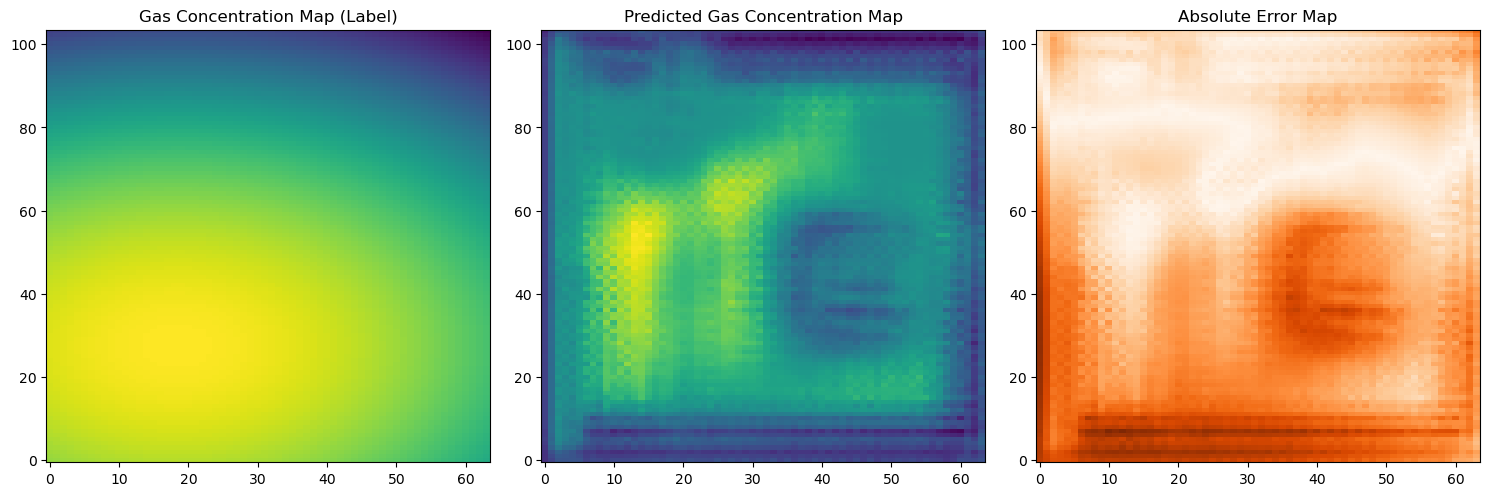

Sample 5:


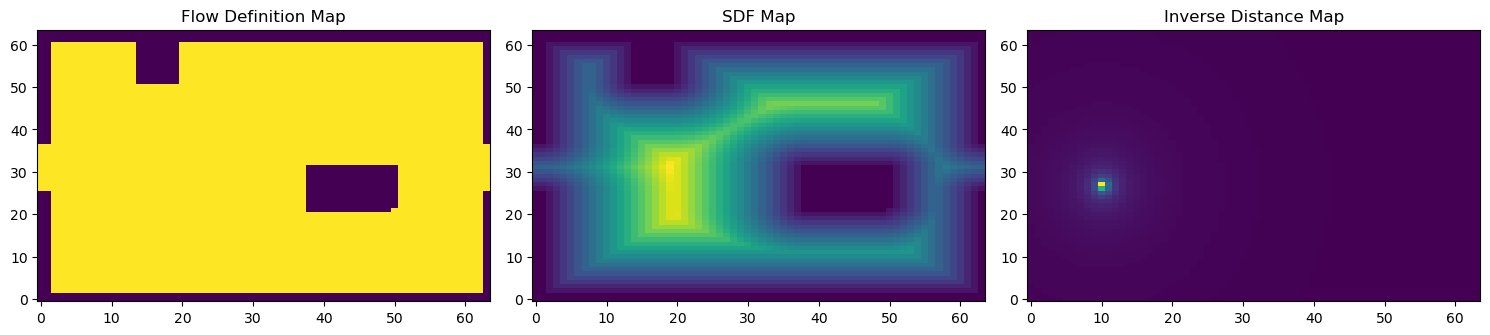

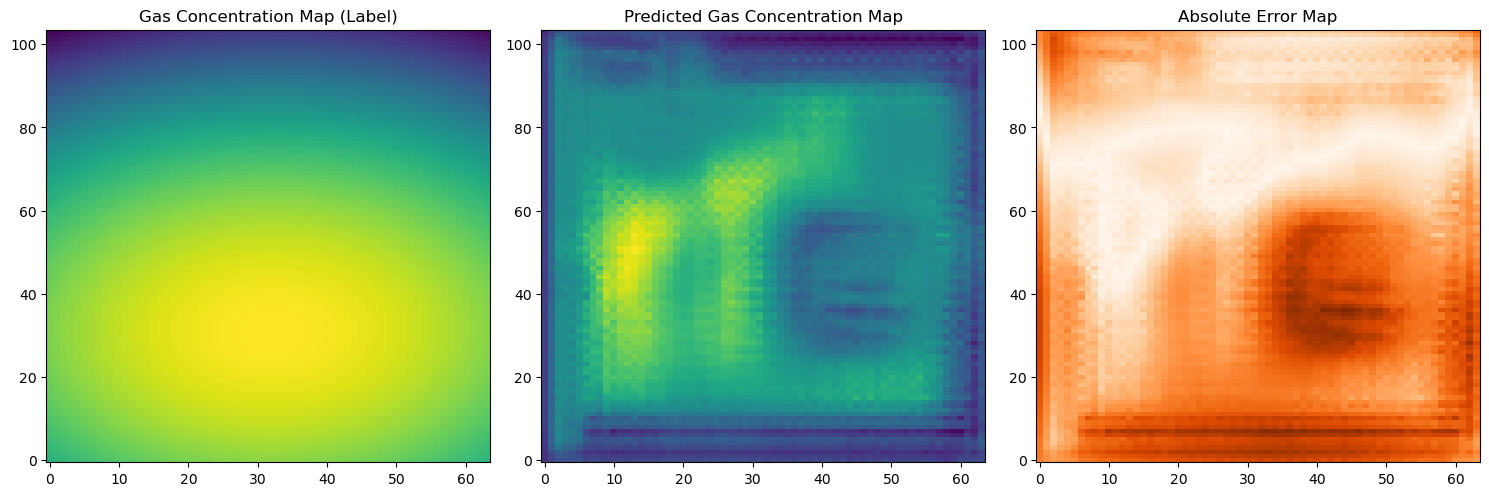

Sample 6:


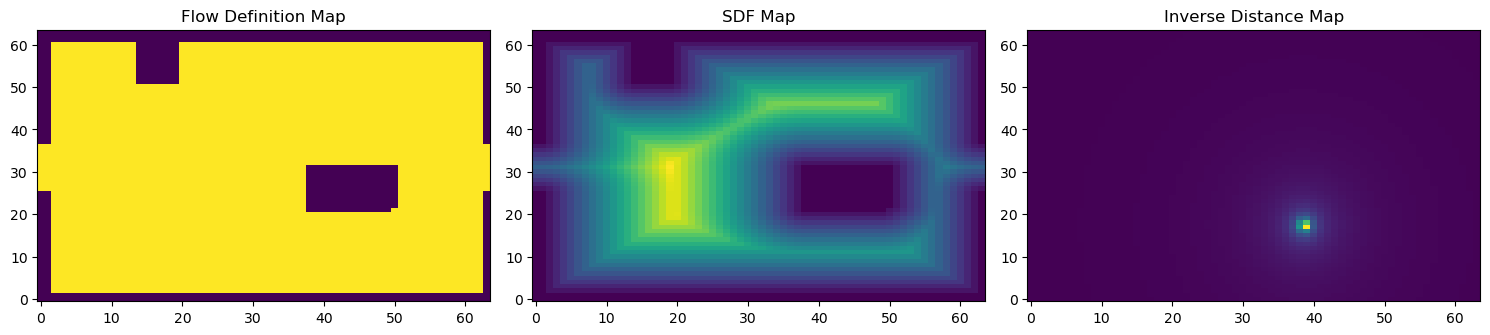

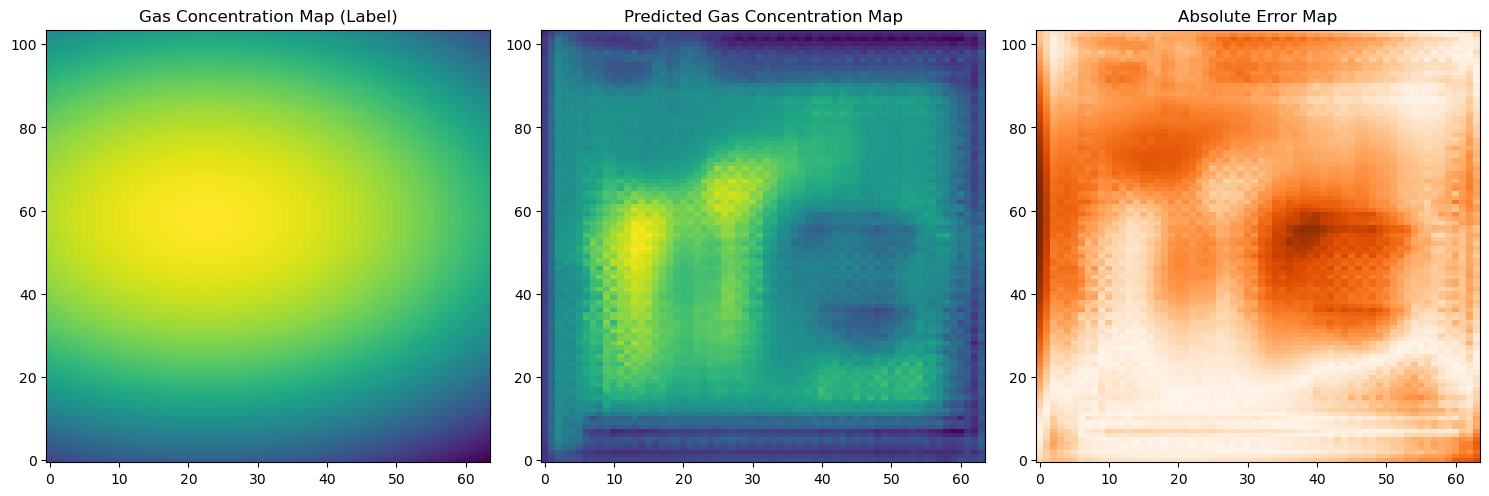

Sample 7:


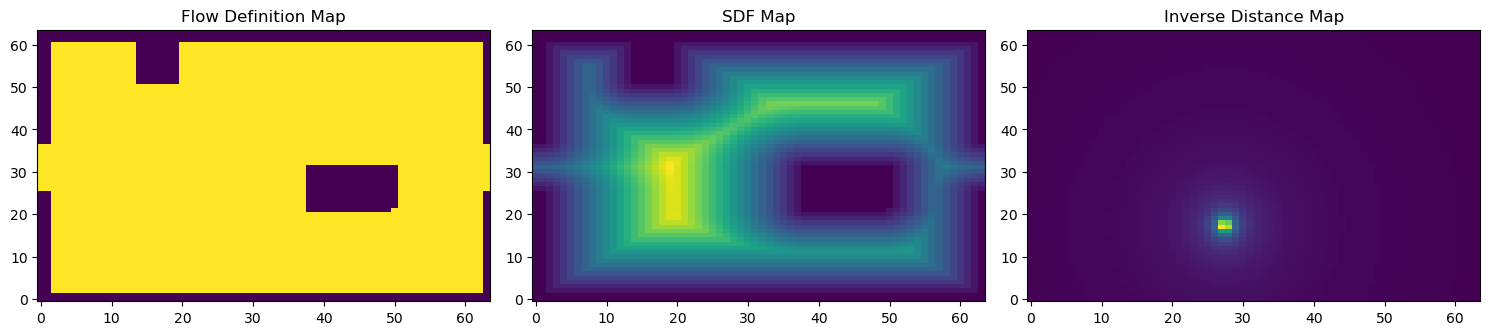

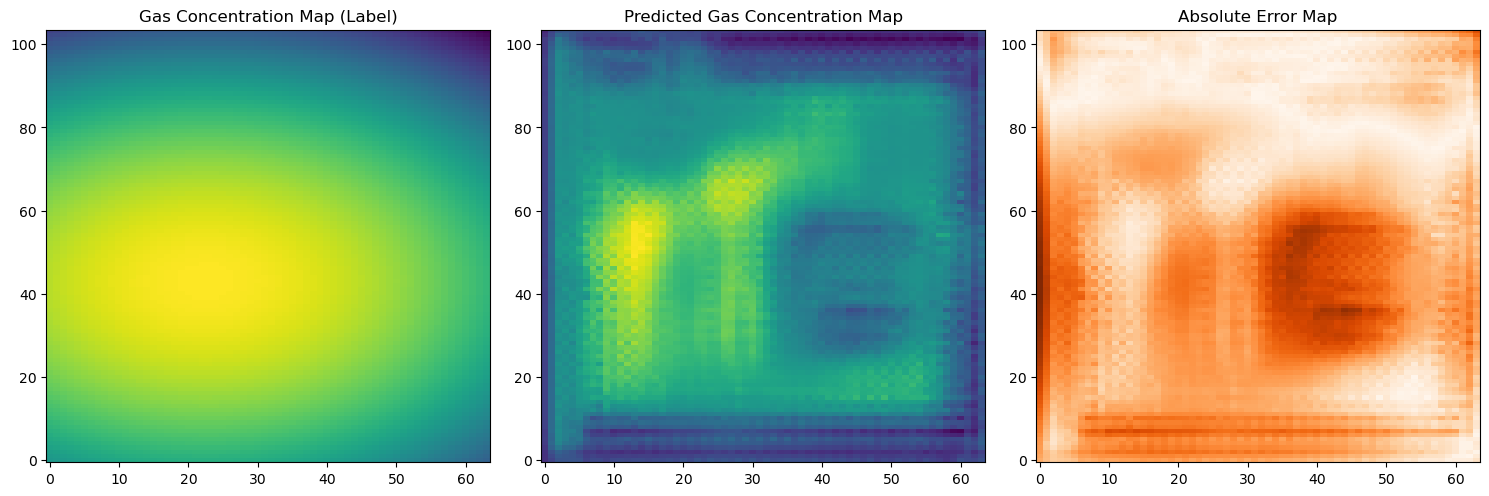

In [31]:
# Visualize prediction and label with absolute error
def visualize_feature_maps(flow_map, sdf_map, inverse_distance_map):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Flow Definition Map
    ax[0].imshow(flow_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[0].set_title('Flow Definition Map')

    # SDF Map
    ax[1].imshow(sdf_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[1].set_title('SDF Map')

    # Inverse Distance Map
    ax[2].imshow(inverse_distance_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[2].set_title('Inverse Distance Map')

    plt.tight_layout()
    plt.show()
    
def visualize_prediction_and_label(label_map, pred_map):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Real gas concentration map
    label_map = label_map.squeeze()  # (1, 104, 64) -> (104, 64)
    ax[0].imshow(label_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[0].set_title('Gas Concentration Map (Label)')

    # Predicted gas concentration map
    pred_map = pred_map.squeeze()  # (1, 104, 64) -> (104, 64)
    ax[1].imshow(pred_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[1].set_title('Predicted Gas Concentration Map')

    # Absolute error map
    abs_error_map = np.abs(label_map - pred_map)
    ax[2].imshow(abs_error_map, cmap='Oranges', origin='lower', aspect=6/10)
    ax[2].set_title('Absolute Error Map')

    plt.tight_layout()
    plt.show()

# Compare model prediction with label
def visualize_prediction(model, loader, num_samples=1):
    model.eval()
    with torch.no_grad():
        for i, (feature_maps, labels) in enumerate(loader):
            feature_maps, labels = feature_maps.to(device), labels.to(device)

            # Model prediction
            predictions = model(feature_maps)

            # Visualization - one batch data 
            for sample in range(num_samples):
                flow_map = feature_maps[sample, 0].cpu().numpy()
                sdf_map = feature_maps[sample, 1].cpu().numpy()
                inv_dist_map = feature_maps[sample, 2].cpu().numpy()
                label_map = labels[sample].cpu().numpy()
                pred_map = predictions[sample].cpu().numpy()

                print(f"Sample {sample+1}:")

                visualize_feature_maps(flow_map, sdf_map, inv_dist_map)
                visualize_prediction_and_label(label_map, pred_map)
            break  
        
visualize_prediction(model, val_loader, num_samples=7)

Sample 1:


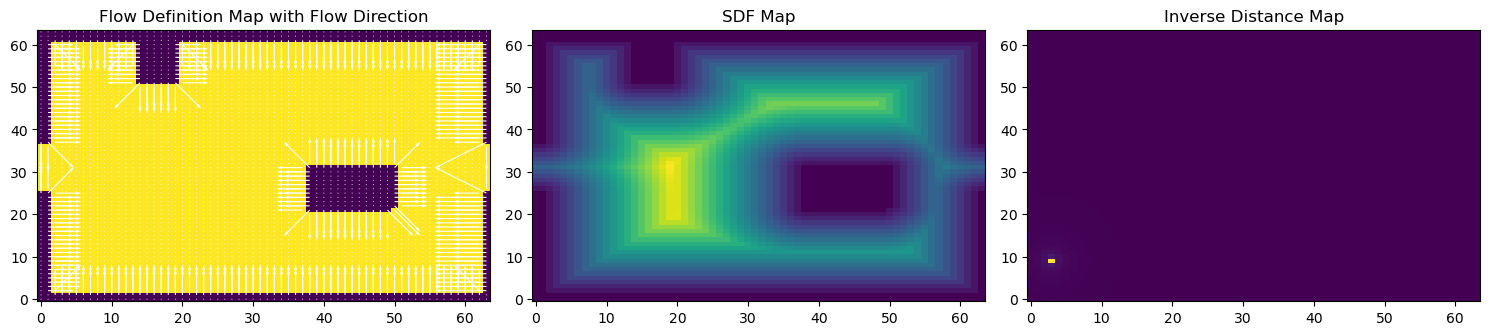

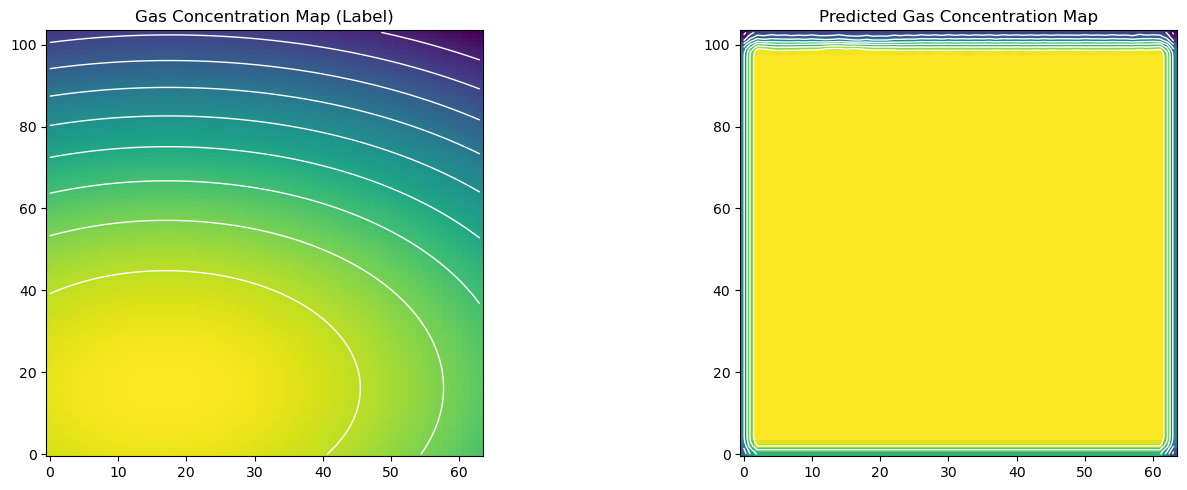

Sample 2:


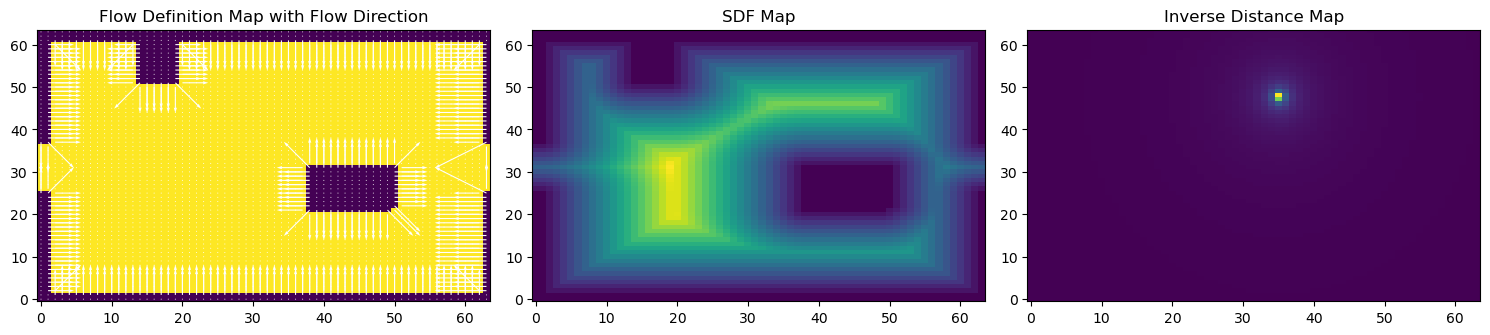

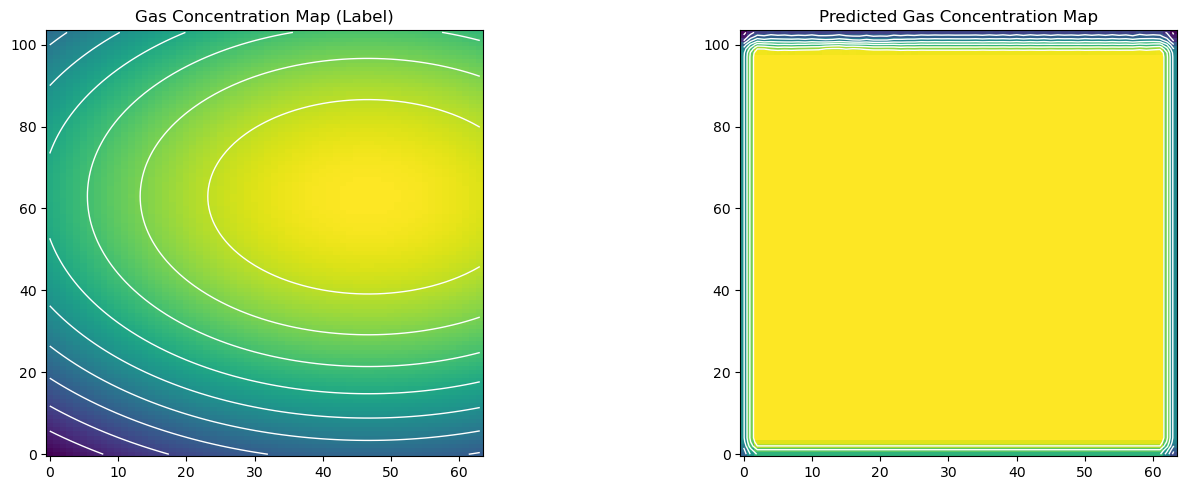

Sample 3:


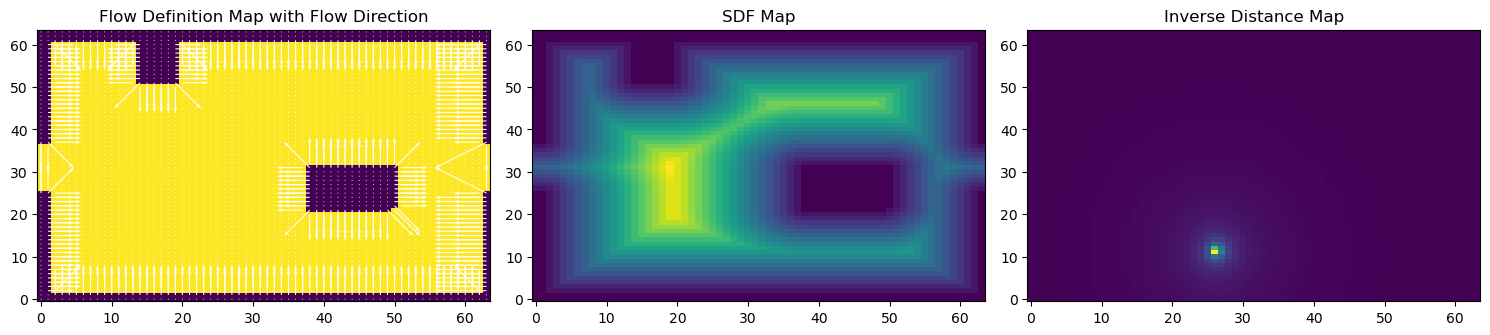

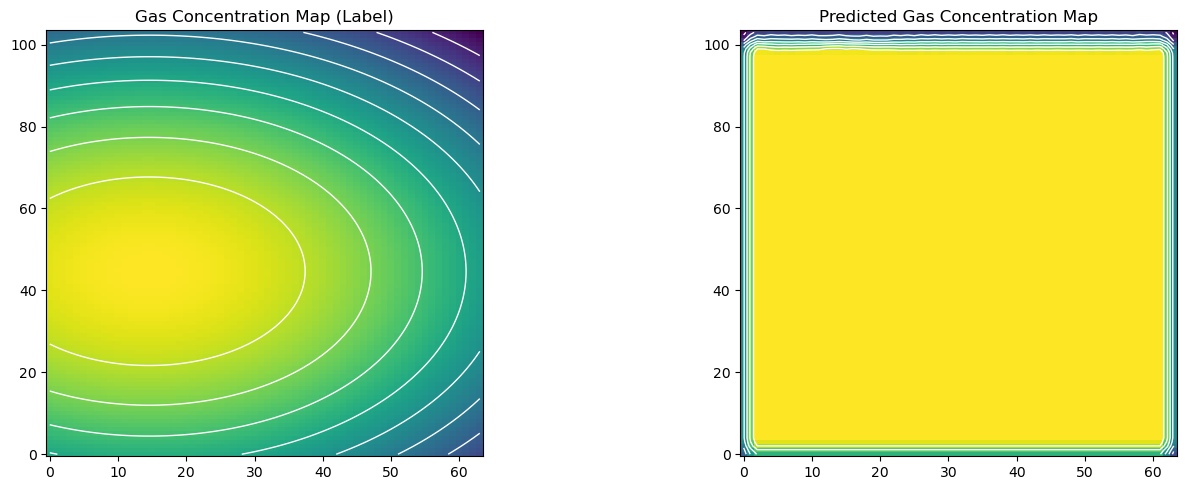

Sample 4:


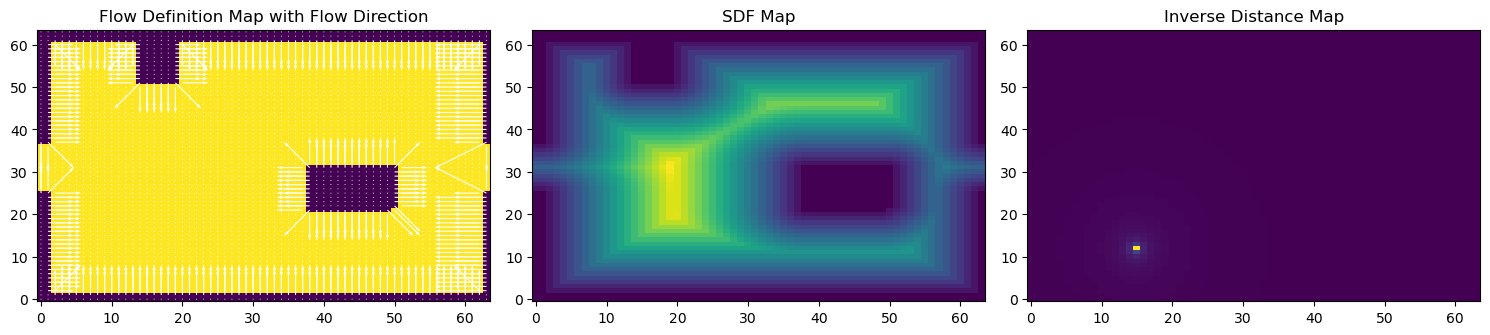

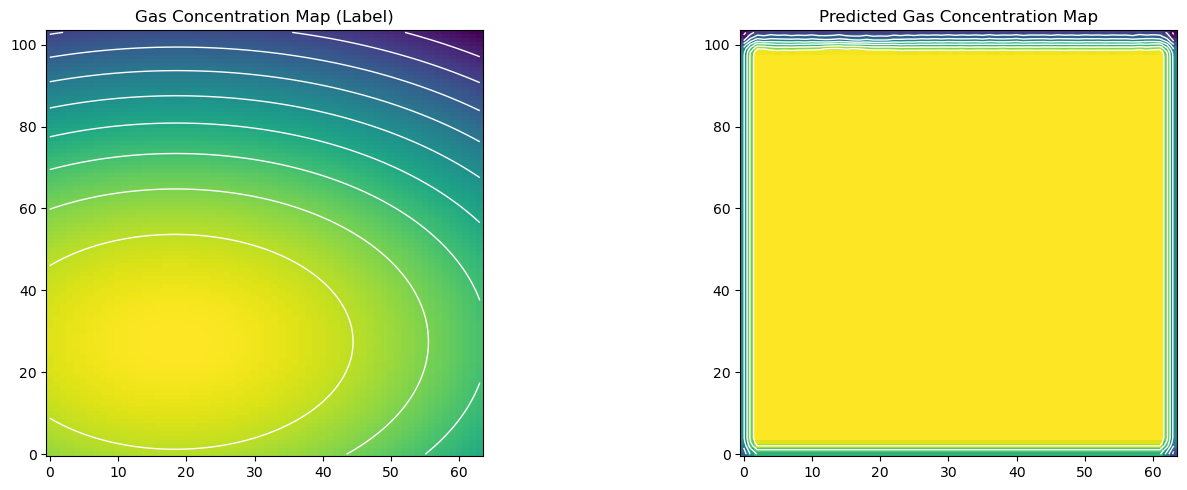

Sample 5:


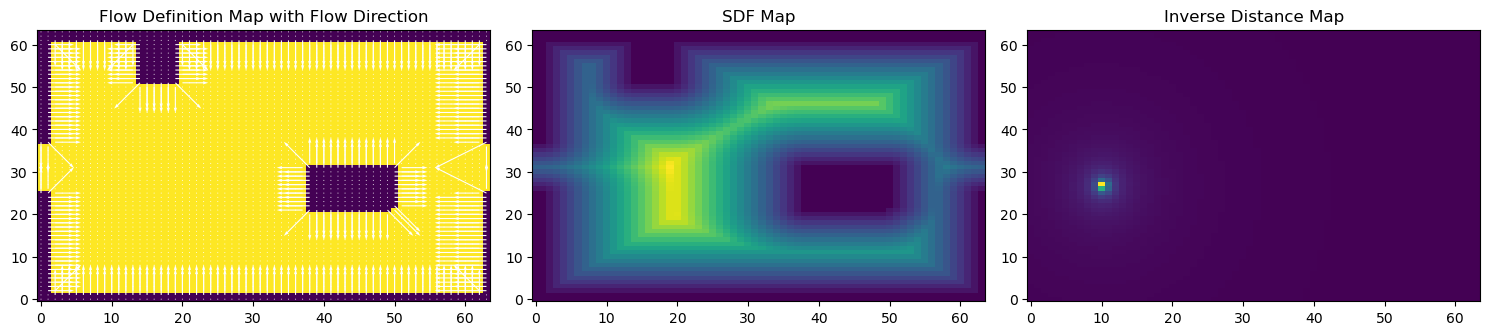

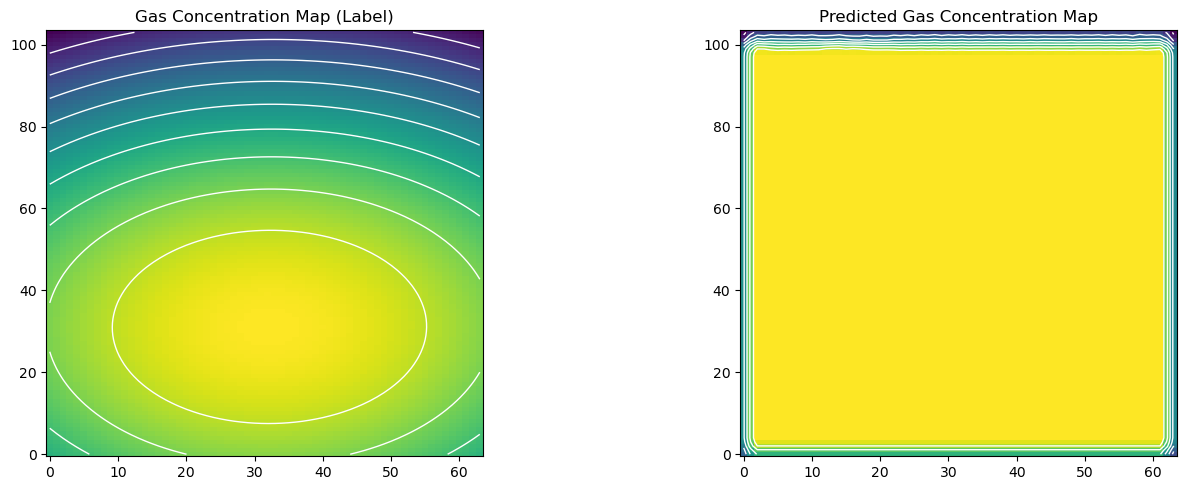

Sample 6:


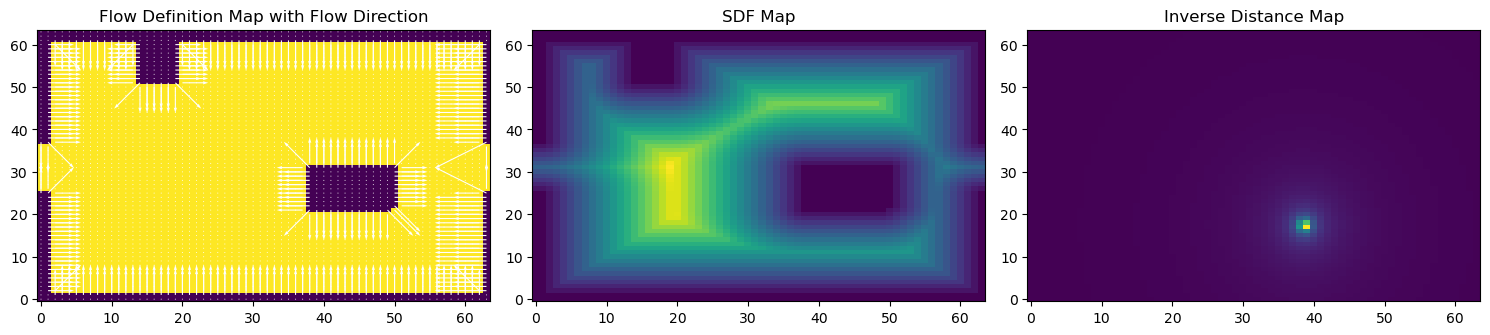

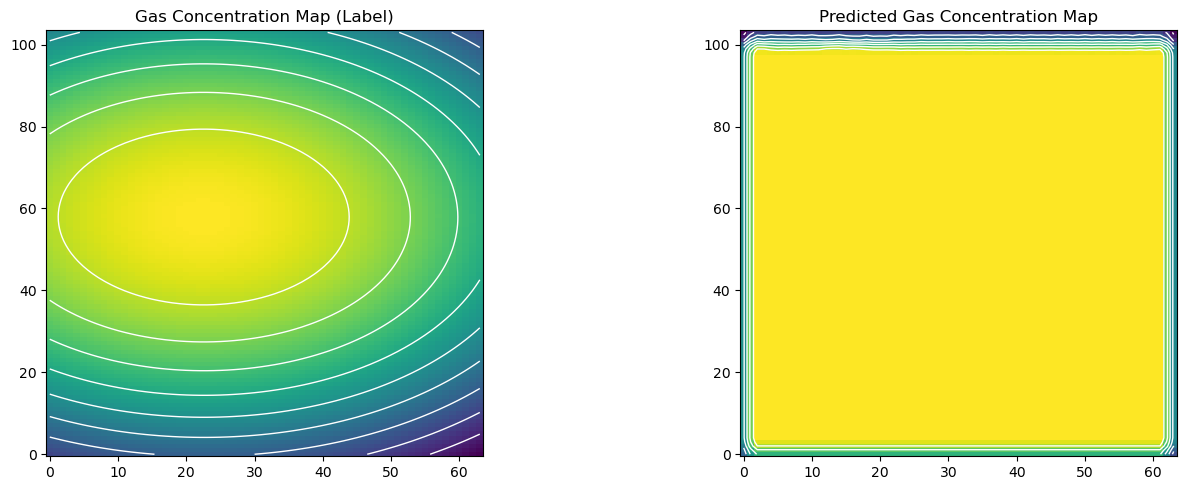

Sample 7:


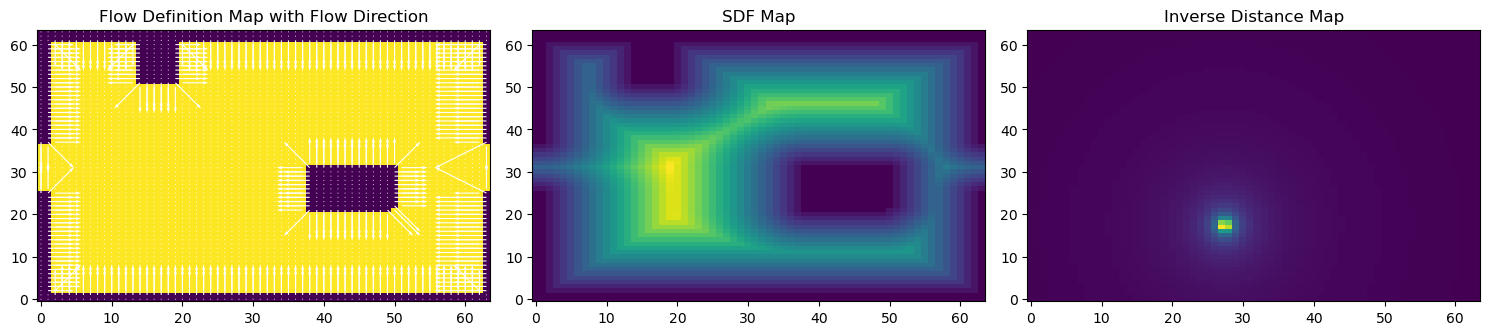

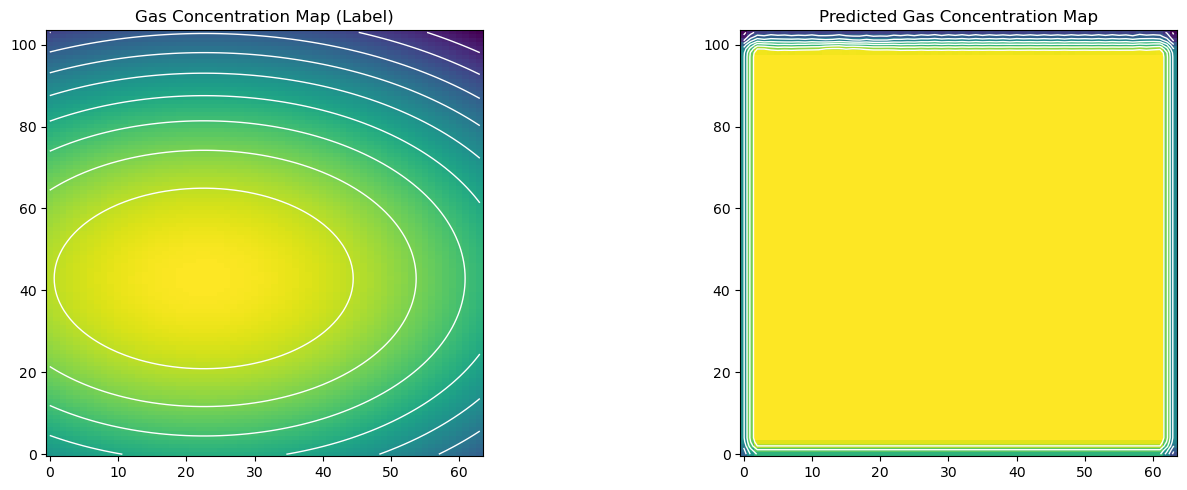

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize feature maps with quiver (flow direction)
def visualize_feature_maps_with_flow(flow_map, sdf_map, inverse_distance_map):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Flow Definition Map with Quiver plot to show direction
    Y, X = np.mgrid[0:flow_map.shape[0], 0:flow_map.shape[1]]
    ax[0].imshow(flow_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[0].quiver(X, Y, np.gradient(flow_map)[1], np.gradient(flow_map)[0], color='white')
    ax[0].set_title('Flow Definition Map with Flow Direction')

    # SDF Map
    ax[1].imshow(sdf_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[1].set_title('SDF Map')

    # Inverse Distance Map
    ax[2].imshow(inverse_distance_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[2].set_title('Inverse Distance Map')

    plt.tight_layout()
    plt.show()

# Visualize prediction and label with contour (gas flow direction)
def visualize_prediction_and_label_with_contour(label_map, pred_map):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Real gas concentration map with contour
    label_map = label_map.squeeze()  # (1, 104, 64) -> (104, 64)
    ax[0].imshow(label_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[0].contour(label_map, colors='white', levels=10, linewidths=1)  # Add contour for flow lines
    ax[0].set_title('Gas Concentration Map (Label)')

    # Predicted gas concentration map with contour
    pred_map = pred_map.squeeze()  # (1, 104, 64) -> (104, 64)
    ax[1].imshow(pred_map, cmap='viridis', origin='lower', aspect=6/10)
    ax[1].contour(pred_map, colors='white', levels=10, linewidths=1)  # Add contour for flow lines
    ax[1].set_title('Predicted Gas Concentration Map')

    plt.tight_layout()
    plt.show()

# Compare model prediction with label and flow
def visualize_prediction_with_flow(model, loader, num_samples=1):
    model.eval()
    with torch.no_grad():
        for i, (feature_maps, labels) in enumerate(loader):
            feature_maps, labels = feature_maps.to(device), labels.to(device)

            # Model prediction
            predictions = model(feature_maps)

            # Visualization - one batch data 
            for sample in range(num_samples):
                flow_map = feature_maps[sample, 0].cpu().numpy()
                sdf_map = feature_maps[sample, 1].cpu().numpy()
                inv_dist_map = feature_maps[sample, 2].cpu().numpy()
                label_map = labels[sample].cpu().numpy()
                pred_map = predictions[sample].cpu().numpy()

                print(f"Sample {sample+1}:")

                # Feature map visualization with flow
                visualize_feature_maps_with_flow(flow_map, sdf_map, inv_dist_map)
                
                # Prediction and label visualization with contour
                visualize_prediction_and_label_with_contour(label_map, pred_map)
            break  
        
# 예시로 시각화 실행
visualize_prediction_with_flow(model, val_loader, num_samples=7)